In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import copy, deepcopy 

Fz=4000 #N 

i=1000
SL=np.linspace(-1,1,i)
IA=0
Fz0=3114 #nominal load (z.b 80% von Fzmax)
    
import sys
import os
sys.path.insert(0, os.path.abspath('../model'))

import Pacejka52_glSA as pa52gl

sys.path.insert(0, os.path.abspath('../model/parameter'))
import Pacejka_Params_Indy as pa

params_Indy = [pa.PHX1, pa.PHX2, pa.PKX1, pa.PKX2, pa.PKX3, pa.PCX1, pa.PDX1, pa.PDX2, pa.PDX3, pa.PEX1, pa.PEX2, pa.PEX4, pa.PVX1, pa.PVX2, pa.LMUX, pa.LEX]

500


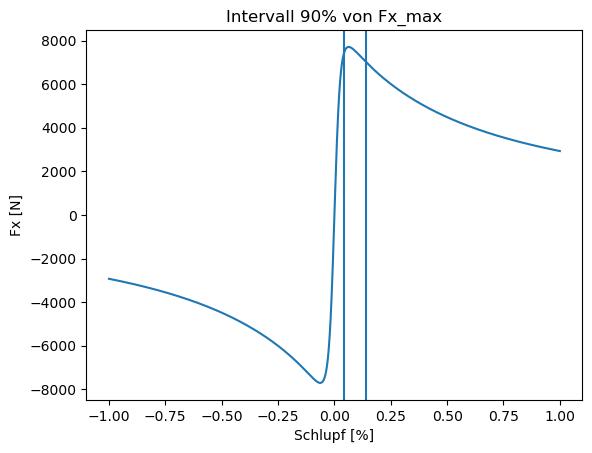

In [3]:
#Vergleichsgrößen

def Fx_intervall(Fz,Fx_intv,params): #Fz in [kN], Fx_intv in % (z.b 10% von Fx_max)
#x Position von Fx_max berechnene
    Fx_w=pa52gl.Pacejka52_long(SL,Fz,Fz0, *params)[0]
    w=len(Fx_w)
    Fx_max_pos=0
    for j in range(0,w):
        if Fx_w[j] == np.max(pa52gl.Pacejka52_long(SL,Fz,Fz0, *params)[0]):
            break
        else:
            Fx_max_pos = Fx_max_pos + 1

    #cut slop
    cut = int(w/2)
    Fx_w_pos = Fx_w[cut::]
    Fx_w_pos_max=Fx_w_pos[0:((Fx_max_pos-cut)+1)] #von 0 bis Fx_max
    Fx_w_max_end=Fx_w_pos[((Fx_max_pos-cut)+1)::] #von Fx_max bis Ende(+100% slipratio)

    Fx_max_ref = np.max(pa52gl.Pacejka52_long(SL,Fz,Fz0, *params)[0]) * Fx_intv #Referenzwert Fx 10% weniger als Fx_max

    left=0
    j=0
    for j in range(0,len(Fx_w_pos_max)):
        if Fx_w_pos_max[j] < Fx_max_ref:
            left +=1
        else:
            break
        
    right = 0
    j=0
    for j in range(0,len(Fx_w_max_end)):
        if Fx_w_max_end[j] > Fx_max_ref:
            right +=1
        else:
            break

#Intervall 10% abweichung von Fx_max = [left,right]
    Fx_max_10=Fx_w[cut+left:cut+len(Fx_w_pos_max)+right]
    Fx_slope_b=((len(Fx_w_pos_max)+right)-left)/(cut/100) #breite des Intervalls in %Schlupf
    
    return Fx_slope_b,Fx_max_10,cut,left,right,Fx_w_pos_max

#plot für datstellung Intervall
Fz = 5000
plt.figure(1)
Fx = pa52gl.Pacejka52_long(SL,Fz,Fz0, *params_Indy)[0]
cut = pa52gl.Pacejka52_long(SL,Fz,Fz0, *params_Indy)[2]
plt.plot(SL,Fx)
plt.xlabel('Schlupf [%]')
plt.ylabel('Fx [N]')
print(Fx_intervall(Fz,0.9,params_Indy)[2])
a = Fx_intervall(Fz,0.9,params_Indy)[3]
b = len(Fx_intervall(Fz,0.9,params_Indy)[5])
plt.axvline(0.042)
plt.axvline(0.138)
plt.title('Intervall 90% von Fx_max')




steps=11
Fz_arr1=np.linspace(8000,18000,steps) #von 1kN bis 10kN Fz
Fz_arr=np.round(Fz_arr1,5)




#Schräglaufsteifkeit über ableiten
#ableiten
def diff_Pacejka(y,SL): #y = Funktion die abgleitet werden soll, Sl = linspace
    dx = SL[1]-SL[0]
    dydx = np.gradient(y, dx)
    return dydx



In [4]:
#größen für lokale SA

s = 0.1 #10% änderung
params_SA = deepcopy(params_Indy)
Fz = 4000 #[N]

Text(0.5, 1.0, 'lokale SA Fx_max, Parameter -10% ')

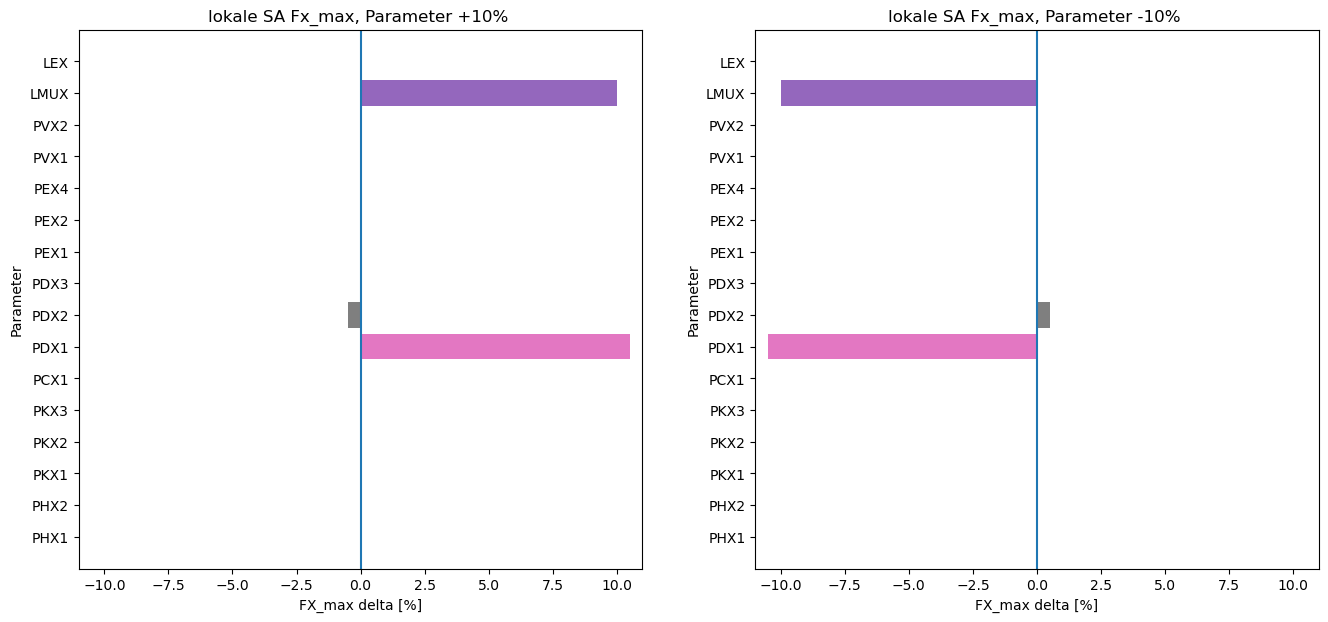

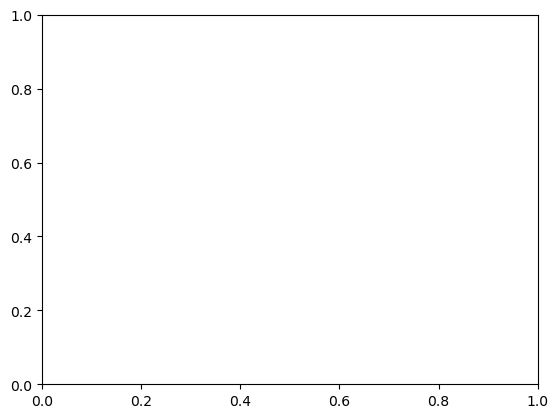

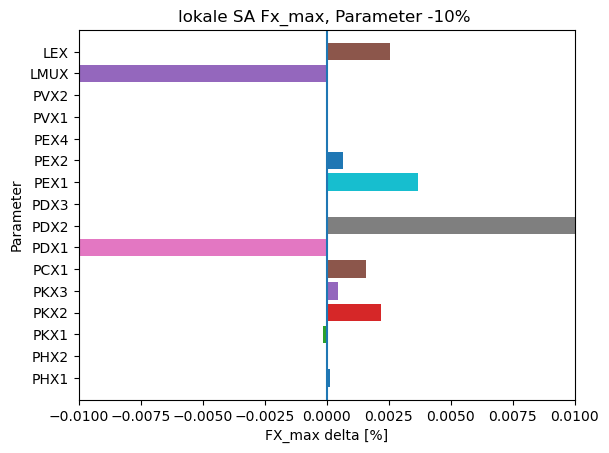

In [5]:
### lokale Sensitivität

#Fx_max, IA = 0.1°
i=0
pramas_Set=params_SA
params=np.zeros((len(pramas_Set),))

for i in range(0,len(pramas_Set)):
    params[i]=params_Indy[i]
    
params_pos = pramas_Set
params_neg = pramas_Set
i=0

delta=np.zeros((len(params),2))

for i in range(0,len(params)):
    
    params_pos[i] = params_pos[i]*(1+s)
    delta_Fx_max_pos = (np.max(pa52gl.Pacejka52_long(SL,Fz,Fz0, *params)[0]) - np.max(pa52gl.Pacejka52_long(SL,Fz,Fz0, *params_pos)[0]))/np.max(pa52gl.Pacejka52_long(SL,Fz,Fz0, *params)[0])
    params_pos[i] = params[i]
    
    params_neg[i] = params_neg[i]*(1-s)
    delta_Fx_max_neg = (np.max(pa52gl.Pacejka52_long(SL,Fz,Fz0, *params)[0]) - np.max(pa52gl.Pacejka52_long(SL,Fz,Fz0, *params_neg)[0]))/np.max(pa52gl.Pacejka52_long(SL,Fz,Fz0, *params)[0])
    params_neg[i] = params[i]
    
    delta[i] = [delta_Fx_max_neg*100, delta_Fx_max_pos*100]
    
i=0
delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(params)):
    delta_pos[i,0] = 0

i=0
for i in range(0,len(params)):
    delta_neg[i,1] = 0


#Plots params -10%
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,7))
y_axis=('PHX1', 'PHX2', 'PKX1', 'PKX2', 'PKX3', 'PCX1', 'PDX1', 'PDX2', 'PDX3', 'PEX1', 'PEX2', 'PEX4', 'PVX1', 'PVX2', 'LMUX', 'LEX')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(y_pos)):
    ax1.barh(y_pos[i],delta_neg[i])
ax1.set_yticks(y_pos, labels=y_axis)
ax1.set_xlim(-11,11)
ax1.set_ylim(-1,len(y_axis))
ax1.axvline(0, 0, 1)
ax1.set_xlabel("FX_max delta [%]")
ax1.set_ylabel("Parameter")
ax1.set_title('lokale SA Fx_max, Parameter +10% ')

#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=('PHX1', 'PHX2', 'PKX1', 'PKX2', 'PKX3', 'PCX1', 'PDX1', 'PDX2', 'PDX3', 'PEX1', 'PEX2', 'PEX4', 'PVX1', 'PVX2', 'LMUX', 'LEX')
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax2.barh(y_pos[i],delta_pos[i])
ax2.set_yticks(y_pos, labels=y_axis)
ax2.set_xlim(-11,11)
ax2.set_ylim(-1,len(y_axis))
ax2.axvline(0, 0, 1)
ax2.set_xlabel("FX_max delta [%]")
ax2.set_ylabel("Parameter")
ax2.set_title('lokale SA Fx_max, Parameter -10% ')

#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=('PHX1', 'PHX2', 'PKX1', 'PKX2', 'PKX3', 'PCX1', 'PDX1', 'PDX2', 'PDX3', 'PEX1', 'PEX2', 'PEX4', 'PVX1', 'PVX2', 'LMUX', 'LEX')
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_pos[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-0.01,0.01)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("FX_max delta [%]")
plt.ylabel("Parameter")
plt.title('lokale SA Fx_max, Parameter -10% ')



Text(0.5, 1.0, 'lokale SA,Slip bei Fx_max, Parameter -10% ')

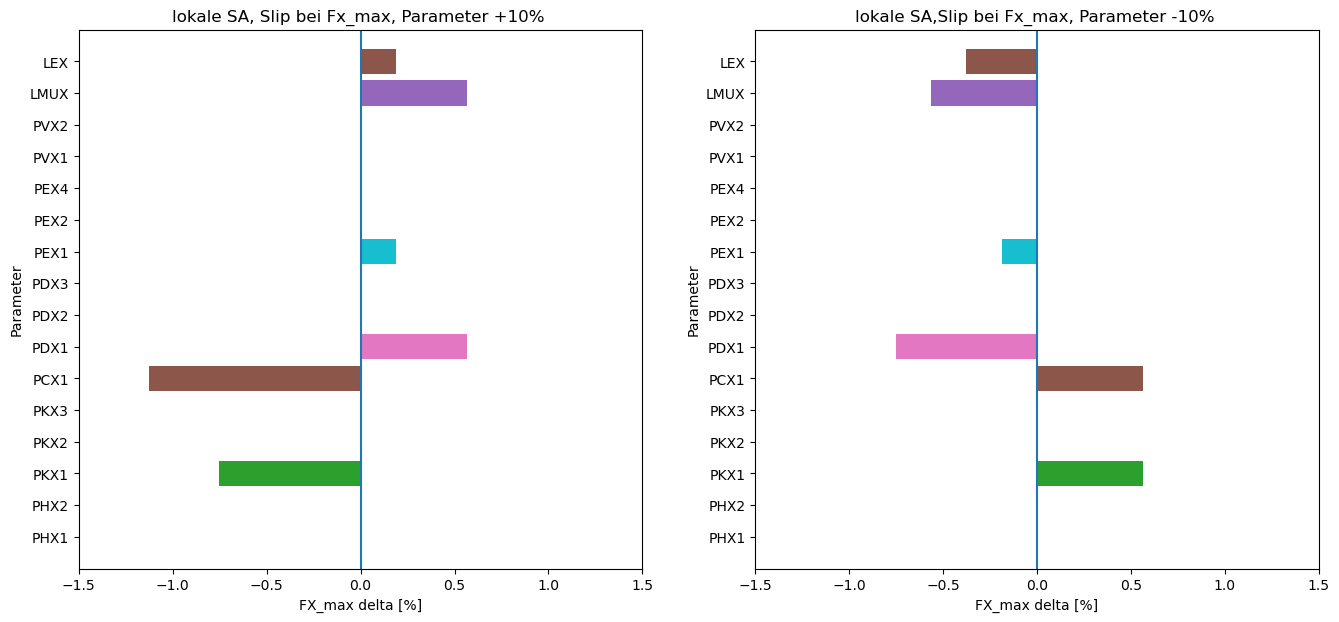

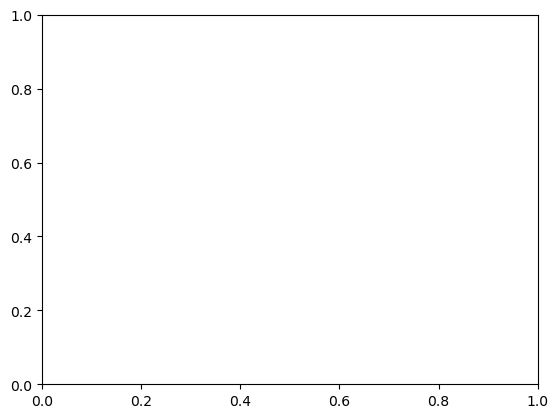

In [6]:
#Sl bei max Fx

#Fx_max#Fz = 4000N, IA = 0.1°
i=0
pramas_Set=params_SA


params=np.zeros((len(pramas_Set),))

for i in range(0,len(pramas_Set)):
    params[i]=params_Indy[i]
    
params_pos = pramas_Set
params_neg = pramas_Set
i=0

delta=np.zeros((len(params),2))

for i in range(0,len(params)):
    
    params_pos[i] = params_pos[i]*(1+s)
    delta_pos = (np.argmax(pa52gl.Pacejka52_long(SL,Fz,Fz0, *params)[0]) - np.argmax(pa52gl.Pacejka52_long(SL,Fz,Fz0, *params_pos)[0]))/(np.argmax(pa52gl.Pacejka52_long(SL,Fz,Fz0, *params)[0]))
    params_pos[i] = params[i]
   
    params_neg[i] = params_neg[i]*(1-s)
    delta_neg = (np.argmax(pa52gl.Pacejka52_long(SL,Fz,Fz0, *params)[0]) - np.argmax(pa52gl.Pacejka52_long(SL,Fz,Fz0, *params_neg)[0]))/(np.argmax(pa52gl.Pacejka52_long(SL,Fz,Fz0, *params)[0]))
    params_neg[i] = params[i]
    
    delta[i] = [delta_neg*100, delta_pos*100]
    
i=0
delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(params)):
    delta_pos[i,0] = 0

i=0
for i in range(0,len(params)):
    delta_neg[i,1] = 0

#Plots params -10%
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,7))
y_axis=('PHX1', 'PHX2', 'PKX1', 'PKX2', 'PKX3', 'PCX1', 'PDX1', 'PDX2', 'PDX3', 'PEX1', 'PEX2', 'PEX4', 'PVX1', 'PVX2', 'LMUX', 'LEX')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(y_pos)):
    ax1.barh(y_pos[i],delta_neg[i])
ax1.set_yticks(y_pos, labels=y_axis)
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(-1,len(y_axis))
ax1.axvline(0, 0, 1)
ax1.set_xlabel("FX_max delta [%]")
ax1.set_ylabel("Parameter")
ax1.set_title('lokale SA, Slip bei Fx_max, Parameter +10% ')

#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=('PHX1', 'PHX2', 'PKX1', 'PKX2', 'PKX3', 'PCX1', 'PDX1', 'PDX2', 'PDX3', 'PEX1', 'PEX2', 'PEX4', 'PVX1', 'PVX2', 'LMUX', 'LEX')
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax2.barh(y_pos[i],delta_pos[i])
ax2.set_yticks(y_pos, labels=y_axis)
ax2.set_xlim(-1.5,1.5)
ax2.set_ylim(-1,len(y_axis))
ax2.axvline(0, 0, 1)
ax2.set_xlabel("FX_max delta [%]")
ax2.set_ylabel("Parameter")
ax2.set_title('lokale SA,Slip bei Fx_max, Parameter -10% ')


Text(0.5, 1.0, 'lokale SA, Slip Intervall (90% von Fx max), Parameter +10% ')

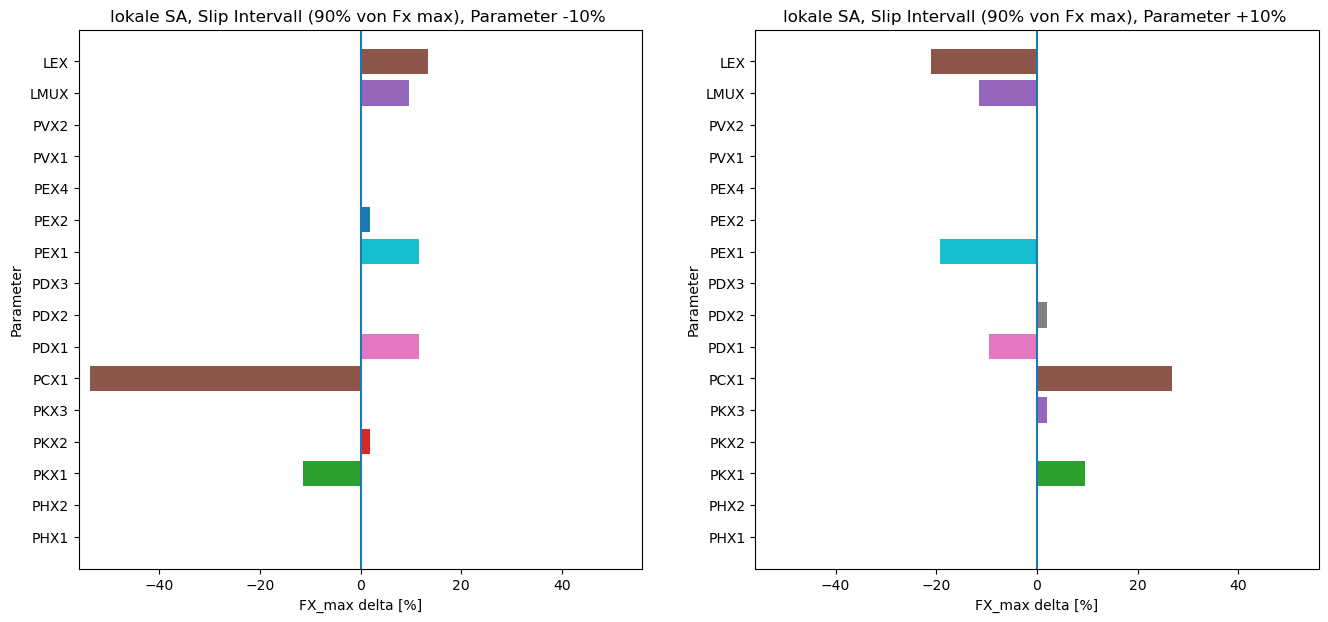

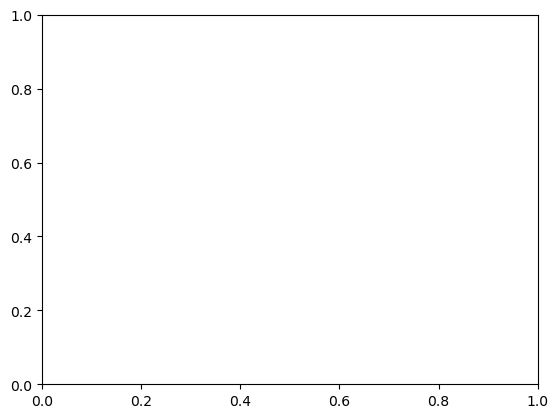

In [7]:
#Slip Intervall (10% von Fx max)

#Fx_max, IA = 0.1°
i=0


pramas_Set=params_SA


params=np.zeros((len(pramas_Set),))

for i in range(0,len(pramas_Set)):
    params[i]=params_Indy[i]
    
params_pos = deepcopy(pramas_Set)
params_neg = deepcopy(pramas_Set)
i=0

delta=np.zeros((len(params),2))

for i in range(0,len(params)):
    
    params_pos[i] = params_pos[i]*(1+s)
    delta_pos = (Fx_intervall(Fz,0.9,params)[0] - Fx_intervall(Fz,0.9,params_pos)[0])/(Fx_intervall(Fz,0.9,params)[0])
    params_pos[i] = params[i]

    params_neg[i] = params_neg[i]*(1-s)
    delta_neg = (Fx_intervall(Fz,0.9,params)[0] - Fx_intervall(Fz,0.9,params_neg)[0])/(Fx_intervall(Fz,0.9,params)[0])
    params_neg[i] = params[i]
    
    delta[i] = [delta_neg*100, delta_pos*100]
    
i=0
delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(params)):
    delta_pos[i,0] = 0

i=0
for i in range(0,len(params)):
    delta_neg[i,1] = 0


#Plots params -10%
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,7))
y_axis=('PHX1', 'PHX2', 'PKX1', 'PKX2', 'PKX3', 'PCX1', 'PDX1', 'PDX2', 'PDX3', 'PEX1', 'PEX2', 'PEX4', 'PVX1', 'PVX2', 'LMUX', 'LEX')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(y_pos)):
    ax1.barh(y_pos[i],delta_neg[i])
ax1.set_yticks(y_pos, labels=y_axis)
ax1.set_xlim(-56,56)
ax1.set_ylim(-1,len(y_axis))
ax1.axvline(0, 0, 1)
ax1.set_xlabel("FX_max delta [%]")
ax1.set_ylabel("Parameter")
ax1.set_title('lokale SA, Slip Intervall (90% von Fx max), Parameter -10% ')

#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=('PHX1', 'PHX2', 'PKX1', 'PKX2', 'PKX3', 'PCX1', 'PDX1', 'PDX2', 'PDX3', 'PEX1', 'PEX2', 'PEX4', 'PVX1', 'PVX2', 'LMUX', 'LEX')
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax2.barh(y_pos[i],delta_pos[i])
ax2.set_yticks(y_pos, labels=y_axis)
ax2.set_xlim(-56,56)
ax2.set_ylim(-1,len(y_axis))
ax2.axvline(0, 0, 1)
ax2.set_xlabel("FX_max delta [%]")
ax2.set_ylabel("Parameter")
ax2.set_title('lokale SA, Slip Intervall (90% von Fx max), Parameter +10% ')

Text(0.5, 1.0, 'lokale SA, Slip Intervall (10% von Fx max), Parameter -10% ')

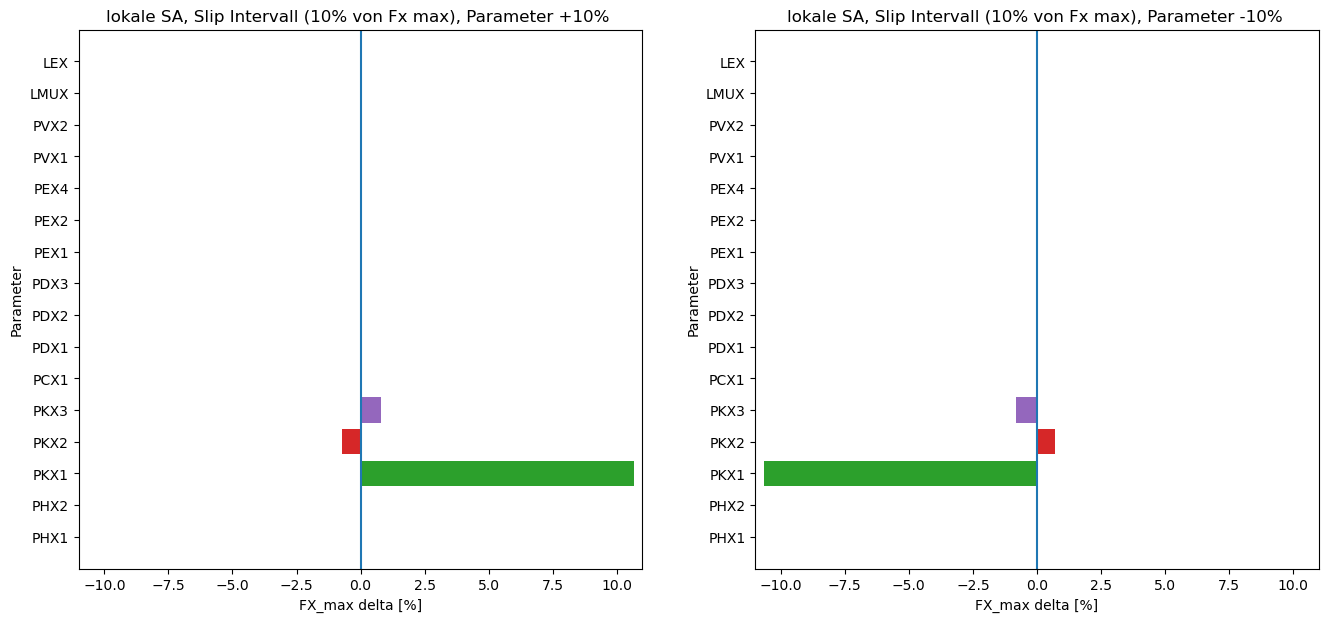

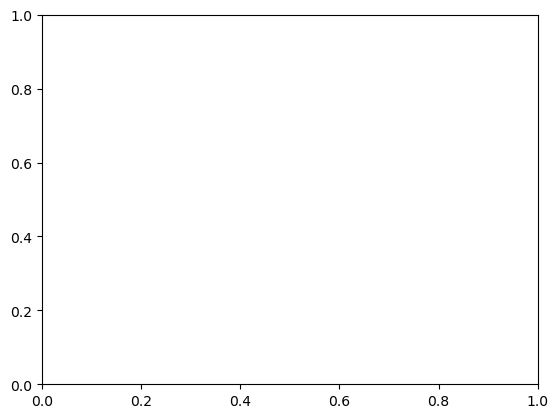

In [8]:
#Schräglaufsteifigkeit 


#Fx_max#Fz = 4000N, IA = 0.1°
i=0

pramas_Set=params_SA


params=np.zeros((len(pramas_Set),))

for i in range(0,len(pramas_Set)):
    params[i]=params_Indy[i]
    
params_pos = pramas_Set
params_neg = pramas_Set
i=0

delta=np.zeros((len(params),2))

iter = len(SL)/2
for i in range(0,len(params)):
    
    params_pos[i] = params_pos[i]*(1+s)
    delta_pos = (diff_Pacejka(pa52gl.Pacejka52_long(SL,Fz,Fz0, *params)[0],SL)[int(iter)] - diff_Pacejka(pa52gl.Pacejka52_long(SL,Fz,Fz0, *params_pos)[0],SL)[int(iter)])/diff_Pacejka(pa52gl.Pacejka52_long(SL,Fz,Fz0, *params)[0],SL)[int(iter)]
    params_pos[i] = params[i]

    params_neg[i] = params_neg[i]*(1-s)
    delta_neg = (diff_Pacejka(pa52gl.Pacejka52_long(SL,Fz,Fz0, *params)[0],SL)[int(iter)] - diff_Pacejka(pa52gl.Pacejka52_long(SL,Fz,Fz0, *params_neg)[0],SL)[int(iter)])/diff_Pacejka(pa52gl.Pacejka52_long(SL,Fz,Fz0, *params)[0],SL)[int(iter)]
    params_neg[i] = params[i]
    
    delta[i] = [delta_neg*100, delta_pos*100]
    
i=0
delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(params)):
    delta_pos[i,0] = 0

i=0
for i in range(0,len(params)):
    delta_neg[i,1] = 0



#Plots params -10%
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,7))
y_axis=('PHX1', 'PHX2', 'PKX1', 'PKX2', 'PKX3', 'PCX1', 'PDX1', 'PDX2', 'PDX3', 'PEX1', 'PEX2', 'PEX4', 'PVX1', 'PVX2', 'LMUX', 'LEX')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(y_pos)):
    ax1.barh(y_pos[i],delta_neg[i])
ax1.set_yticks(y_pos, labels=y_axis)
ax1.set_xlim(-11,11)
ax1.set_ylim(-1,len(y_axis))
ax1.axvline(0, 0, 1)
ax1.set_xlabel("FX_max delta [%]")
ax1.set_ylabel("Parameter")
ax1.set_title('lokale SA, Slip Intervall (10% von Fx max), Parameter +10% ')

#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=('PHX1', 'PHX2', 'PKX1', 'PKX2', 'PKX3', 'PCX1', 'PDX1', 'PDX2', 'PDX3', 'PEX1', 'PEX2', 'PEX4', 'PVX1', 'PVX2', 'LMUX', 'LEX')
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax2.barh(y_pos[i],delta_pos[i])
ax2.set_yticks(y_pos, labels=y_axis)
ax2.set_xlim(-11,11)
ax2.set_ylim(-1,len(y_axis))
ax2.axvline(0, 0, 1)
ax2.set_xlabel("FX_max delta [%]")
ax2.set_ylabel("Parameter")
ax2.set_title('lokale SA, Slip Intervall (10% von Fx max), Parameter -10% ')

#--> Schräglaufsteifigkeit sehr wenig von einzelnen parametern abhängig
#Vorzeichen überprüfen !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#Lokale SA Schräglaufsteifigkeit Fz, abhängig